In [8]:
import pandas as pd

# Carregar o arquivo CSV
file_path = '/content/Dados Históricos - Ibovespa (1).csv'
data = pd.read_csv(file_path)

# Exibir as primeiras linhas do DataFrame para análise
print(data.head())



         Data  Último  Abertura  Máxima  Mínima   Vol.    Var%
0  11.09.2014  58.337    58.202  58.809  58.112  2,89M   0,24%
1  12.09.2014  56.928    58.336  58.336  56.666  4,62M  -2,42%
2  15.09.2014  57.949    56.930  57.949  56.852  2,90M   1,79%
3  16.09.2014  59.115    57.949  60.243  57.946  4,88M   2,01%
4  17.09.2014  59.108    59.115  60.025  59.096  3,53M  -0,01%


In [9]:
# Verificar tipos de dados e colunas
print(data.info())

# Verificar estatísticas descritivas das colunas
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2481 non-null   object 
 1   Último    2481 non-null   float64
 2   Abertura  2481 non-null   float64
 3   Máxima    2481 non-null   float64
 4   Mínima    2481 non-null   float64
 5   Vol.      2480 non-null   object 
 6   Var%      2481 non-null   object 
dtypes: float64(4), object(3)
memory usage: 135.8+ KB
None
            Último     Abertura       Máxima       Mínima
count  2481.000000  2481.000000  2481.000000  2481.000000
mean     89.925035    89.894826    90.724453    89.088683
std      27.060639    27.053079    27.172850    26.928158
min      37.497000    37.501000    38.031000    37.046000
25%      63.954000    63.940000    64.456000    63.366000
50%      96.999000    96.996000    97.879000    95.874000
75%     113.001000   112.922000   114.091000   111.927000
max     137.344000  

In [10]:
# Converter a coluna Data para datetime
data['Data'] = pd.to_datetime(data['Data'], format='%d.%m.%Y')


In [13]:
def convert_volume(value):
    value = str(value)  # Converter para string para verificar as unidades
    if 'B' in value:
        return float(value.replace('B', '').replace(',', '.')) * 1e9
    elif 'M' in value:
        return float(value.replace('M', '').replace(',', '.')) * 1e6
    elif 'K' in value:
        return float(value.replace('K', '').replace(',', '.')) * 1e3
    else:
        return float(value.replace(',', '.'))

# Aplicar a função de conversão à coluna 'Vol.'
data['Vol.'] = data['Vol.'].apply(convert_volume)




In [14]:
# Verificar tipos de dados após conversão
print(data.info())

# Verificar valores ausentes
print(data.isnull().sum())

# Verificar valores duplicados
print(data.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      2481 non-null   datetime64[ns]
 1   Último    2481 non-null   float64       
 2   Abertura  2481 non-null   float64       
 3   Máxima    2481 non-null   float64       
 4   Mínima    2481 non-null   float64       
 5   Vol.      2480 non-null   float64       
 6   Var%      2481 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 135.8+ KB
None
Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64
0


In [15]:
# Ordenar os dados por data
data = data.sort_values('Data')

# Definir a coluna 'Último' como a série temporal
ts_data = data[['Data', 'Último']]


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar o scaler
scaler = MinMaxScaler()

# Normalizar a coluna 'Último' diretamente no DataFrame original
ts_data.loc[:, 'Último'] = scaler.fit_transform(ts_data[['Último']])


In [17]:
import numpy as np

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Definir o comprimento da sequência
seq_length = 60  # Por exemplo, 60 dias

# Criar sequências de dados
X, y = create_sequences(ts_data['Último'].values, seq_length)

# Dividir os dados em treinamento e teste
split = int(0.8 * len(X))  # 80% para treinamento e 20% para teste
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [18]:
# Verificar as dimensões dos conjuntos de dados
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1936, 60)
y_train shape: (1936,)
X_test shape: (485, 60)
y_test shape: (485,)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape dos dados para o formato [amostras, timesteps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Treinar o modelo
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1082 - val_loss: 0.0098
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.8504e-04 - val_loss: 0.0011
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.4964e-04 - val_loss: 9.7783e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.6427e-04 - val_loss: 0.0011
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.7637e-04 - val_loss: 8.7877e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 5.1682e-04 - val_loss: 6.5515e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.5587e-04 - val_loss: 0.0010
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.5985e-04 - val_loss: 6.4876e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.8896e-04 - val_loss: 7.4090e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.7366e-04 - val_loss: 7.5064e-04
Epoch 12/50
49

Loss on test data: 0.000281470303889364


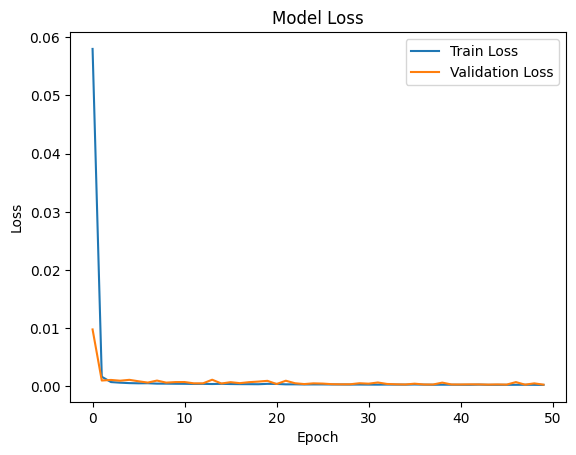

In [20]:
import matplotlib.pyplot as plt

# Avaliar o modelo
loss = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Loss on test data: {loss}")

# Plotar a perda durante o treinamento
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_reshaped)

# Desnormalizar as previsões e os valores reais
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [22]:
import numpy as np

def evaluate_performance(y_true, y_pred, tolerance=0.05):
    """
    Avalia o desempenho do modelo calculando o MAPE e a acurácia com base em uma tolerância.

    Parameters:
    - y_true: Array com os valores reais.
    - y_pred: Array com os valores previstos.
    - tolerance: Tolerância para calcular a acurácia (padrão é 5%).

    Returns:
    - None
    """
    # Calcular MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        """Calcula o MAPE"""
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calcular acurácia
    def calculate_accuracy(y_true, y_pred, tolerance):
        """Calcula a acurácia com base em uma tolerância"""
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        tolerance_value = tolerance * y_true
        correct_predictions = np.abs(y_true - y_pred) <= tolerance_value
        return np.mean(correct_predictions) * 100

    # Calcular MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"MAPE: {mape:.2f}%")

    # Calcular a acurácia
    accuracy = calculate_accuracy(y_true, y_pred, tolerance)
    print(f"Acurácia: {accuracy:.2f}%")

# Exemplo de uso:
evaluate_performance(y_test_original, y_pred_original, tolerance=0.05)


MAPE: 1.13%
Acurácia: 99.79%


In [24]:
def calculate_daily_closure(y_pred):
    """
    Calcula o fechamento diário com base no valor mais recente da previsão.

    Parameters:
    - y_pred: Array com os valores previstos.

    Returns:
    - None
    """
    # Pegar o valor mais recente previsto (caso seja um array multidimensional, pegar o valor escalar)
    daily_closure = y_pred[-1]

    # Se daily_closure for um array, pegue o primeiro elemento
    if isinstance(daily_closure, np.ndarray):
        daily_closure = daily_closure[0]

    # Exibir o fechamento diário
    print(f"Fechamento diário previsto: {daily_closure:.2f}")

# Exemplo de uso:
calculate_daily_closure(y_pred_original)



Fechamento diário previsto: 132.73
